# Python Notebook for Facial Expression Classification Fine-Tuned Model

In this notebook, our Fine Tuned classification model is defined and trained and then validated by our validation dataset.

## Dowloading Data (FER 2013):

Installing **Kaggle** Package Manager for downloading data from Kaggle.

In [ ]:
! pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Here we are making directory where we want to place **kaggle.json** so that kaggle package can get permission to download the dataset.

In [ ]:
! mkdir ~/.kaggle

Copy the **kaggle.json** to our created directory.

In [ ]:
!cp kaggle.json ~/.kaggle/

Adding Security permissions to the file.

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

Download the dataset in zip format.

In [ ]:
!kaggle datasets download -d msambare/fer2013

 98% 59.0M/60.3M [00:02<00:00, 37.2MB/s]
100% 60.3M/60.3M [00:02<00:00, 29.2MB/s]


Unzip the data in the root folder.

In [ ]:
!unzip fer2013.zip

Streaming output truncated to the last 5000 lines.
  inflating: train/sad/Training_65242339.jpg  
  inflating: train/sad/Training_65267116.jpg  
  inflating: train/sad/Training_65275626.jpg  
  inflating: train/sad/Training_6529266.jpg  
  inflating: train/sad/Training_65329617.jpg  
  inflating: train/sad/Training_65338712.jpg  
  inflating: train/sad/Training_65338797.jpg  
  inflating: train/sad/Training_65387162.jpg  
  inflating: train/sad/Training_65404494.jpg  
  inflating: train/sad/Training_65426218.jpg  
  inflating: train/sad/Training_65430136.jpg  
  inflating: train/sad/Training_65437377.jpg  
  inflating: train/sad/Training_6545735.jpg  
  inflating: train/sad/Training_65463385.jpg  
  inflating: train/sad/Training_65473985.jpg  
  inflating: train/sad/Training_65502829.jpg  
  inflating: train/sad/Training_65505359.jpg  
  inflating: train/sad/Training_65508578.jpg  
  inflating: train/sad/Training_65516023.jpg  
  inflating: train/sad/Training_65524027.jpg  
  inflating

## Importing Libraries:

Here are the some required libraries.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import numpy as np

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

## Transformations and Data Loaders:

This code defines some image transformations using PyTorch's transforms module for the training dataset. The mean and std variables define the mean and standard deviation for normalization of the image pixels.

The train_transforms variable is a Compose object that chains together multiple image transformations to be applied sequentially to each training image. The transformations applied in this example are:

    RandomAffine: randomly applies affine transformations to the image, such as rotation, translation, and scaling
    RandomHorizontalFlip: randomly flips the image horizontally
    RandomVerticalFlip: randomly flips the image vertically
    ToTensor: converts the image to a PyTorch tensor
    Normalize: normalizes the tensor values using the specified mean and std values

Each transformation is applied in the order they are listed in the Compose object.

In [ ]:
mean = np.array([0.5, 0.5, 0.5])
std = np.array([0.25, 0.25, 0.25])
train_transforms = transforms.Compose([transforms.Resize((160, 160)), transforms.RandomAffine(degrees = 10, translate = (0.1, 0.1)), transforms.RandomHorizontalFlip(), transforms.RandomVerticalFlip(), transforms.ToTensor(), transforms.Normalize(mean, std)])

This code loads the training and test datasets and creates data loaders for them.

The ImageFolder function from torchvision.datasets is used to create datasets from images in directories. In this case, the training and test images are located in ./train and ./test directories, respectively. The transform argument specifies the transformations to be applied to the images, which are defined in the train_transforms variable for the training dataset, and a separate set of ToTensor and Normalize transformations for the test dataset.

The DataLoader function from torch.utils.data is used to create data loaders that can load the data in batches during training and testing. The batch_size argument specifies the number of images in each batch, and the shuffle argument indicates whether the data should be shuffled before each epoch. The training and test loaders are created separately, with different batch sizes, but both with shuffling enabled.

In [ ]:
train_dataset = torchvision.datasets.ImageFolder('./train', transform=train_transforms)
test_dataset = torchvision.datasets.ImageFolder('./test', transform=transforms.Compose([transforms.Resize((160, 160)), transforms.ToTensor(), transforms.Normalize(mean, std)]))

train_loader = DataLoader(train_dataset, batch_size=200, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=100, shuffle=False)

In [ ]:
images, labels = next(iter(train_loader))
input_features = images.shape[1]
batch_size = images.shape[0]
out_features = labels.shape[0]
hidden_features = 16

Here is the dictionary for converting index to classes and classes to index.

In [ ]:
class2index = train_dataset.class_to_idx
index2class = dict([(value, key) for key, value in class2index.items()])

Here is the pictorial representaion of images in our dataset

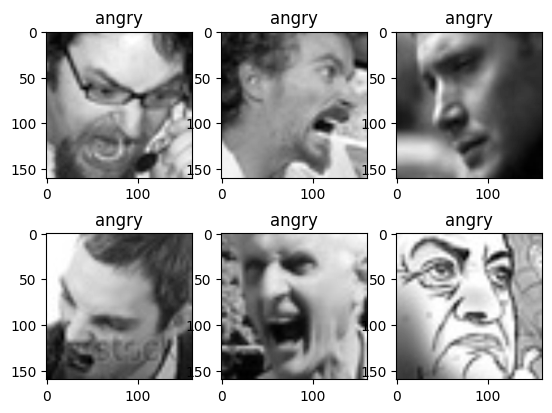

In [ ]:
images, labels = next(iter(test_loader))
for i in range(6):
  plt.subplot(2, 3, i+1)
  plt.imshow(images[i][0], cmap="gray")
  plt.title(index2class[labels[i].item()])
plt.show()

## Model Creation:

Here we install **Facenet** Package in order to use pre-train model.

In [ ]:
!pip install facenet-pytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Load our Pre Train Model that is **vggface2** :

In [ ]:
from facenet_pytorch import InceptionResnetV1
model_ft = InceptionResnetV1(pretrained='vggface2', classify=False, num_classes = 7)

Get all the layers except the last **Fully Connected(FC) Layers**, Ignore the last layers as we have to rebuild them from scratch.

In [ ]:
model_ft = nn.Sequential(*list(model_ft.children())[:-5])

All the parameters of the model is set to freeze.

In [ ]:
for param in model_ft.parameters():
    param.requires_grad = False

Define the classes which defines the flatten and the normalization function

In [ ]:
class Flatten(nn.Module):
    def __init__(self):
        super(Flatten, self).__init__()
        
    def forward(self, x):
        x = x.view(x.size(0), -1)
        return x
        
class normalize(nn.Module):
    def __init__(self):
        super(normalize, self).__init__()
        
    def forward(self, x):
        x = F.normalize(x, p=2, dim=1)
        return x

Adding the Average Pool, then flatten the features, then add the linear layer after which the features are normalized and then add the last linear layer.

In [ ]:
model_ft.avgpool_1a = nn.AdaptiveAvgPool2d(output_size=1)
model_ft.last_linear = nn.Sequential(
    Flatten(),
    nn.Linear(in_features=1792, out_features=512, bias=False),
    normalize()
)
model_ft.logits = nn.Linear(512, 7)

Then, here is our final model:
<br><br>
The **Pictorial Representation** of our final model is given below:
<br><br>
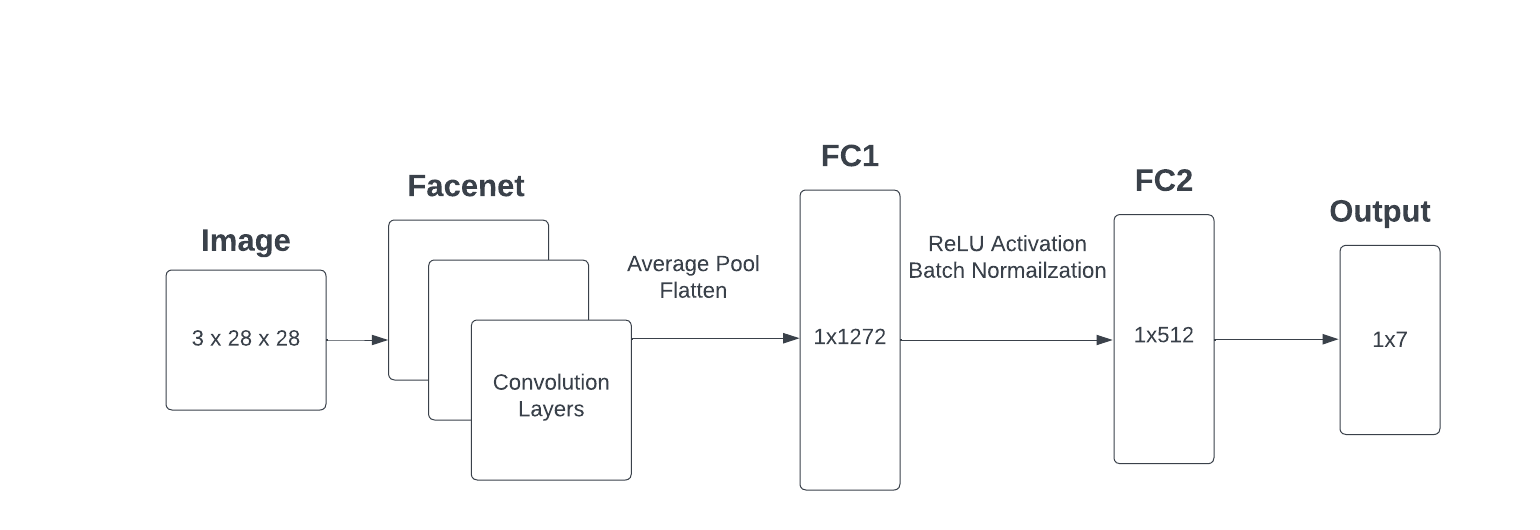

In [ ]:
model_ft

Sequential(
  (0): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (1): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (2): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (5): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3,


The code then trains the model on a training dataset and validates it on a test dataset for a specified number of epochs. During each epoch, the model is first set to training mode and trained on batches of data using stochastic gradient descent (SGD) optimizer with a cross-entropy loss function. Then, the model is set to evaluation mode and evaluated on the test dataset to calculate its accuracy.

The history dictionary is used to store the loss and accuracy values during the training process. The best model is saved based on the lowest loss and highest accuracy values achieved during the training process.

Overall, the given code is an implementation of a CNN model using PyTorch for image classification, with training and validation on a dataset, and a mechanism to save the best model based on loss and accuracy.

In [ ]:
learning_rate = 0.001
model_ft = model_ft.to(device)
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_ft.parameters(), lr=learning_rate)
epochs = 15
history = {
    "Loss": [],
    "Accuracy": []
}

best_loss = float('inf')
best_acc = 0.0

for epoch in range(epochs):
    model_ft.train()  # Set model to training mode

    acc_loss = 0
    for i, (input, labels) in enumerate(train_loader):
        input = input.to(device)
        labels = labels.to(device)

        y_pred = model_ft(input)
        l = loss(y_pred, labels)
        acc_loss += l.item()

        optimizer.zero_grad()
        l.backward()
        optimizer.step()

    avg_loss = acc_loss / len(train_dataset)  # Calculate average loss per sample
    history['Loss'].append(avg_loss)

    print(f"Epoch [{epoch+1}/{epochs}]:")
    print(f"Train Loss: {avg_loss:.3f}")

    model_ft.eval()  # Set model to evaluation mode

    with torch.no_grad():
        n_correct = 0
        for input, labels in test_loader:
            input = input.to(device)
            labels = labels.to(device)
            y_pred_test = model_ft(input)
            _, index = torch.max(y_pred_test, 1)
            n_correct += (labels == index).sum().item()
        acc = n_correct / len(test_dataset)  # Calculate accuracy on test dataset
        print(f"Test Accuracy: {acc:.3f}")
        history['Accuracy'].append(acc)

        # Save model based on loss and accuracy
        if avg_loss < best_loss and acc > best_acc:
            best_loss = avg_loss
            best_acc = acc
            torch.save(model_ft.state_dict(), "best_model_loss.pth")
            print("Best model saved!")

Epoch [1/15]:
Train Loss: 0.008
Test Accuracy: 0.500
Best model saved!
Epoch [2/15]:
Train Loss: 0.007
Test Accuracy: 0.523
Best model saved!
Epoch [3/15]:
Train Loss: 0.006
Test Accuracy: 0.554
Best model saved!
Epoch [4/15]:
Train Loss: 0.006
Test Accuracy: 0.560
Best model saved!
Epoch [5/15]:
Train Loss: 0.006
Test Accuracy: 0.563
Best model saved!
Epoch [6/15]:
Train Loss: 0.006
Test Accuracy: 0.564
Best model saved!
Epoch [7/15]:
Train Loss: 0.006
Test Accuracy: 0.569
Best model saved!
Epoch [8/15]:
Train Loss: 0.006
Test Accuracy: 0.576
Best model saved!
Epoch [9/15]:
Train Loss: 0.006
Test Accuracy: 0.571
Epoch [10/15]:
Train Loss: 0.006
Test Accuracy: 0.574
Epoch [11/15]:
Train Loss: 0.006
Test Accuracy: 0.576
Best model saved!
Epoch [12/15]:
Train Loss: 0.006
Test Accuracy: 0.571
Epoch [13/15]:
Train Loss: 0.006
Test Accuracy: 0.571
Epoch [14/15]:
Train Loss: 0.006
Test Accuracy: 0.575
Epoch [15/15]:
Train Loss: 0.006
Test Accuracy: 0.573


## Model Testing:

Here are the cells that calculates the overall accuracy and then plot the training cycle of the given model.

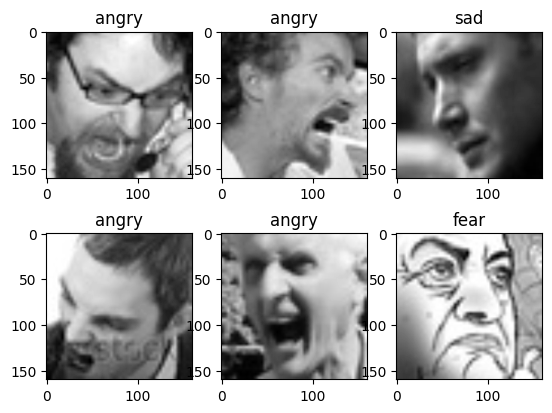

In [ ]:
model_ft.eval()
images, labels = next(iter(test_loader))
for i in range(6):
  input = images[i].to(device)
  input = torch.unsqueeze(input, axis=0)
  y_pred_test = model_ft(input)
  value, index = torch.max(y_pred_test, 1)
  plt.subplot(2, 3, i+1)
  plt.imshow(images[i][0], cmap="gray")
  plt.title(index2class[index.item()])
plt.show()

Here is the plot of the trend of loss and accuracy in the training of our model.

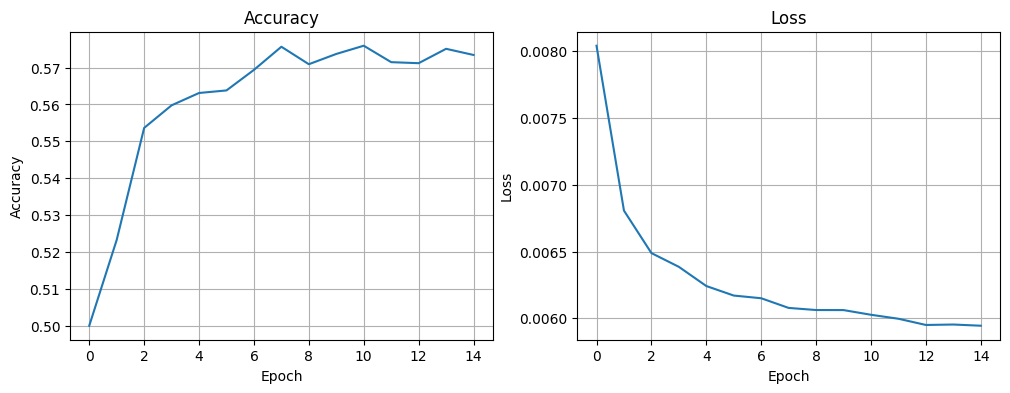

In [ ]:
# Plot accuracy and loss
plt.figure(figsize=(12, 4))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history['Accuracy'])
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history['Loss'])
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

plt.show()

## Load Our Saved Model and Test:

In [ ]:
load_model = model_ft.to(device)
checkpoint_path = '/content/best_model_loss.pth'
checkpoint = torch.load(checkpoint_path)
load_model.load_state_dict(checkpoint)

<All keys matched successfully>

In [ ]:
load_model.eval()
pred_labels = np.array([])
actual_labels = np.array([])
with torch.no_grad():
  n_correct = 0
  for input, labels in test_loader:
    input = input.to(device)
    labels = labels.to(device)
    y_pred_test = load_model(input)
    _, index = torch.max(y_pred_test, 1)
    pred_labels = np.append(pred_labels, index.cpu().numpy())
    actual_labels = np.append(actual_labels, labels.cpu().numpy())
    n_correct += (labels == index).sum().item()
  acc = n_correct/(len(test_loader)*100)
  print(f"Accuracy :: {acc}")

Accuracy :: 0.5741666666666667


Here are our **Evaluation Metrics** for the testing of our model

In [ ]:
from sklearn.metrics import confusion_matrix

confusion_mat = confusion_matrix(y_true=actual_labels, y_pred=pred_labels)

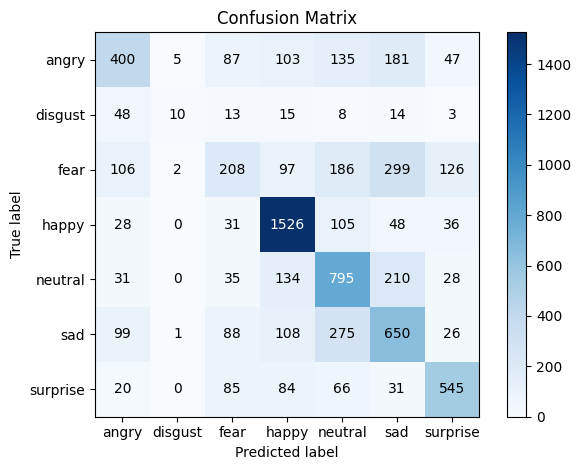

In [ ]:
# Define class labels
class_labels = list(class2index.keys())

# Create figure and axis
fig, ax = plt.subplots()

# Plot confusion matrix
im = ax.imshow(confusion_mat, interpolation='nearest', cmap=plt.cm.Blues)

# Add colorbar
cbar = ax.figure.colorbar(im, ax=ax)

# Set labels
ax.set(xticks=np.arange(confusion_mat.shape[1]),
       yticks=np.arange(confusion_mat.shape[0]),
       xticklabels=class_labels, yticklabels=class_labels,
       title='Confusion Matrix',
       ylabel='True label',
       xlabel='Predicted label')

# Loop over data dimensions and add text annotations
thresh = confusion_mat.max() / 2.
for i in range(confusion_mat.shape[0]):
    for j in range(confusion_mat.shape[1]):
        ax.text(j, i, format(confusion_mat[i, j], 'd'),
                ha="center", va="center",
                color="white" if confusion_mat[i, j] > thresh else "black")

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

In [ ]:
from sklearn.metrics import classification_report
report = classification_report(actual_labels,pred_labels, target_names=list(class2index.keys()))
print(report)

              precision    recall  f1-score   support

       angry       0.55      0.42      0.47       958
     disgust       0.56      0.09      0.16       111
        fear       0.38      0.20      0.26      1024
       happy       0.74      0.86      0.79      1774
     neutral       0.51      0.64      0.57      1233
         sad       0.45      0.52      0.49      1247
    surprise       0.67      0.66      0.66       831

    accuracy                           0.58      7178
   macro avg       0.55      0.48      0.49      7178
weighted avg       0.56      0.58      0.56      7178

